In [1]:
using Multilane
using POMDPModelTools
using POMDPs
using POMDPPolicies
using POMDPSimulators
using Random
using MCTS
using AutoViz
using Reel
using POMCPOW
using ProgressMeter
using AutomotiveDrivingModels
using ImageView
using Images


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3249222083181663061\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6791477420513213569\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-3249222083181663061\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
#Set up problem configuration
nb_lanes = 4
pp = PhysicalParam(nb_lanes,lane_length=100.) #2.=>col_length=8
_discount = 1.
nb_cars=10

rmodel = NoCrashRewardModel()

dmodel = NoCrashIDMMOBILModel(nb_cars, pp)

mdp = NoCrashMDP{typeof(rmodel), typeof(dmodel.behaviors)}(dmodel, rmodel, _discount, true);

rng = MersenneTwister(5)

s = rand(rng, initialstate(mdp))
# @show s.env_cars[1]
#visualize(mdp,s,MLAction(0,0))

policy = RandomPolicy(mdp)

sim = HistoryRecorder(rng=rng, max_steps=100) # initialize a random number generator

hist = simulate(sim, mdp, policy, s);

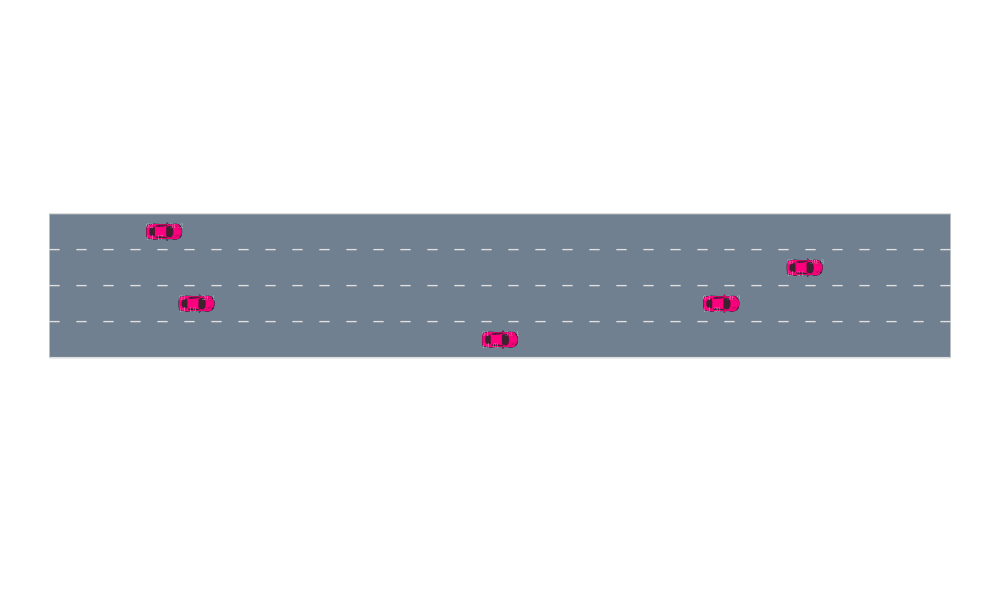

In [10]:
s = state_hist(hist)[1]
a = first(action_hist(hist))
sp = state_hist(hist)[2]
Multilane.visualize(mdp, s, a, sp)
# savefig("scene_1.pdf")

In [14]:

behaviors = standard_uniform(correlation=0.75)
pp = PhysicalParam(4, lane_length=120.0)
dmodel = NoCrashIDMMOBILModel(10, pp,
                              behaviors=behaviors,
                              p_appear=1.0,
                              lane_terminate=true,
                              max_dist=1000.0
                             )
rmodel = SuccessReward(lambda=1.0, speed_thresh=20.0, lane_change_cost=0.05)
pomdp = NoCrashPOMDP{typeof(rmodel), typeof(dmodel.behaviors)}(dmodel, rmodel, 0.95, true);

if !isdefined(:hist) || hist === nothing
    rng = MersenneTwister(15)

    s = initial_state(pomdp, rng)

    @show n_iters = 1000
    @show max_time = Inf
    @show max_depth = 40
    @show val = SimpleSolver()

    wup = WeightUpdateParams(smoothing=0.0, wrong_lane_factor=0.5)
    solver = POMCPOWSolver(tree_queries=n_iters,
                           criterion=MaxUCB(2.0),
                           max_depth=max_depth,
                           max_time=max_time,
                           enable_action_pw=false,
                           k_observation=2.0,
                           alpha_observation=1/20,
                           estimate_value=FORollout(val),
                           # estimate_value=val,
                           check_repeat_obs=false,
                           node_sr_belief_updater=BehaviorPOWFilter(wup),
                           rng=MersenneTwister(7),
                           tree_in_info=true,
                           default_action=MLAction(0.0, 0.0) # maintain at the end
                          )
    planner = solve(solver, pomdp)

    sim = HistoryRecorder(rng=rng, max_steps=100, show_progress=true) # initialize a random number generator

    up = BehaviorParticleUpdater(pomdp, 1000, 0.1, 0.1, wup, MersenneTwister(50000))

    hist = simulate(sim, pomdp, planner, up, MLPhysicalState(s), s)
end

@show discounted_reward(hist)

#=
fpstep = 6
sh = state_hist(hist)
surfaces = []
surfdir = tempname()
mkdir(surfdir)
frames = Frames(MIME("image/png"), fps=fpstep/pp.dt)
@showprogress for (s, ai, r, sp) in eachstep(hist, "s, ai, r, sp")
    tree = get(ai, :tree, nothing)
    rollouts = make_rollouts(planner, tree)
    nwr = NodeWithRollouts(POWTreeObsNode(tree, 1), rollouts)
    for t in linspace(0.0, 1.0, fpstep)
        if s.t == 0.0 || t > 0.0
            is = interp_state(s, sp, t)
            # fname = joinpath(surfdir, string(length(surfaces)+1)*".svg")
            # surf = CairoSVGSurface(fname, AutoViz.DEFAULT_CANVAS_WIDTH, AutoViz.DEFAULT_CANVAS_HEIGHT)
            # push!(surfaces, visualize(pomdp, is, r, tree=nwr, surface=surf))
            push!(surfaces, visualize(pomdp, is, r, tree=nwr))
            push!(frames, last(surfaces))
        end
    end
end

# simulate a little farther with another policy
sdm = deepcopy(dmodel)
sdm.lane_terminate = false
sdm.max_dist = 1200 # give the car some extra room at the end
spomdp = NoCrashPOMDP{typeof(rmodel), typeof(dmodel.behaviors)}(sdm, rmodel, 0.95, true);
s = last(state_hist(hist))
s.terminal = nothing
policy = Multilane.BehaviorPolicy(spomdp, Multilane.NORMAL, true, rng)
bonus_hist = simulate(sim, spomdp, policy, up, MLPhysicalState(s), s)
@showprogress for (s, r, sp) in eachstep(bonus_hist, "s,r,sp")
    for t in linspace(0.0, 1.0, fpstep)
        if t > 0.0
            is = interp_state(s, sp, t)
            push!(frames, visualize(spomdp, is, r))
        end
    end
end

gifname = tempname()*".ogv"
write(gifname, frames)
run(`xdg-open $gifname`)
# gif = load(gifname)
# imshow(gif)
=#

# extract at 19.50
@show fname = joinpath("/tmp", "selected_frame.svg")
selected = nothing
for (s, ai, r, sp) in eachstep(hist, "s, ai, r, sp")
    tree = get(ai, :tree, nothing)
    rollouts = make_rollouts(planner, tree)
    nwr = NodeWithRollouts(POWTreeObsNode(tree, 1), rollouts)
    if s.t <= 19.5 && sp.t > 19.5
        is = interp_state(s, sp, (19.5-s.t)/(sp.t-s.t))
        surf = CairoSVGSurface(fname, AutoViz.DEFAULT_CANVAS_WIDTH, AutoViz.DEFAULT_CANVAS_HEIGHT)
        selected = visualize(pomdp, is, r, tree=nwr, surface=surf)
    end
end
finish(selected)


Multilane.visualize(mdp, s_hist[i], a_hist[i], s_hist[i + 1]) = Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000005b079a30, 1000.0, 600.0, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1))
